<a href="https://colab.research.google.com/github/aromaldev/OCR-Malayalam/blob/master/classification/machinelearning/Random_Forest_using_P_arts_Compounded_characters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the packages

In [ ]:
from google.colab import drive
import os
import pickle

#Image Processing
import cv2
from skimage.filters import sobel_v,sobel_h,sobel

import matplotlib.pyplot as plt
import numpy as np

# Sklearn 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Extract files to the Runtime

In [ ]:
!ls /content/drive/MyDrive/dataset
#!sh -c "mkdir thirtyclasses && tar -C thirtyclasses -x -f /content/drive/MyDrive/dataset/thirtyclasses.tar"
!sh -c "mkdir dataset && cd dataset && unzip /content/drive/MyDrive/dataset/P-ARTS\ KAYYEZHUTHU\ MALAYALAM\ HANDWRITTEN\ DATASET/Compound_MAL_characters.zip"


Streaming output truncated to the last 5000 lines.
  inflating: EXPANNEW/CHAR8/MD1887.JPG  
  inflating: EXPANNEW/CHAR8/MD1888.JPG  
  inflating: EXPANNEW/CHAR8/MD1889.JPG  
  inflating: EXPANNEW/CHAR8/MD189.JPG  
  inflating: EXPANNEW/CHAR8/MD1890.JPG  
  inflating: EXPANNEW/CHAR8/MD1891.JPG  
  inflating: EXPANNEW/CHAR8/MD1892.JPG  
  inflating: EXPANNEW/CHAR8/MD1893.JPG  
  inflating: EXPANNEW/CHAR8/MD1894.JPG  
  inflating: EXPANNEW/CHAR8/MD1895.JPG  
  inflating: EXPANNEW/CHAR8/MD1896.JPG  
  inflating: EXPANNEW/CHAR8/MD1897.JPG  
  inflating: EXPANNEW/CHAR8/MD1898.JPG  
  inflating: EXPANNEW/CHAR8/MD1899.JPG  
  inflating: EXPANNEW/CHAR8/MD19.JPG  
  inflating: EXPANNEW/CHAR8/MD190.JPG  
  inflating: EXPANNEW/CHAR8/MD1900.JPG  
  inflating: EXPANNEW/CHAR8/MD1901.JPG  
  inflating: EXPANNEW/CHAR8/MD1902.JPG  
  inflating: EXPANNEW/CHAR8/MD1903.JPG  
  inflating: EXPANNEW/CHAR8/MD1904.JPG  
  inflating: EXPANNEW/CHAR8/MD1905.JPG  
  inflating: EXPANNEW/CHAR8/MD1906.JPG  
  inflatin

## Feature Extraction

In [ ]:
def centroid(img_org):
    img = img_org.copy()
    ret,thresh = cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
    thresh = cv2.GaussianBlur(src=thresh,ksize=(3,5),sigmaX=0) 
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cnt = contours[0]
    M = cv2.moments(cnt)
    #print( M )
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    return (cx,cy)

In [ ]:
def getAspectRatio(img):
    smooth = img.copy()
    smooth = cv2.GaussianBlur(src=smooth,ksize=(3,3),sigmaX=0)
    edged = cv2.Canny(smooth, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    #Detect the contours
    contours,hierarchy = cv2.findContours(image = edged,mode=cv2.RETR_TREE,method=cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    # Apply the bounding box on the image
    x,y,w,h = cv2.boundingRect(cnt)
    aspectRatio = w/h
    return aspectRatio

## Import the data

In [ ]:
base_dir = './dataset/EXPANNEW'
image_per_class = 3500
img_width = 32
img_height = 32

In [ ]:
images = []
flist = []
labels = []

for directory, sub_dir,filenames in os.walk(base_dir):
    if sub_dir != []:
        class_names = sub_dir
        continue
    i=0
    #label = directory.split('/')[-1]
    #if label not in labels:
    for file in filenames:
        if  i < image_per_class and (file.endswith('.jpg') or file.endswith('.JPG')):
            flist.append(file)
            img = cv2.imread(os.path.join(directory,file),cv2.IMREAD_GRAYSCALE)
            if type(img) == type(None):
                continue
            img = cv2.resize(img,(img_width,img_height),interpolation=cv2.INTER_LANCZOS4)
            #print(os.path.join(directory,file))

            feature_vector = np.float32(img.flatten())
            images.append(feature_vector)

            labels.append(directory.split('/')[-1][4:])
            i+=1
    print(f"Recived {i} images from{directory}")

images = np.array(images,dtype=np.float32)
#images = (images - np.average(images))/np.std(images)
labels = np.array(labels,dtype=np.uint8)

class_names = [ int(x[4:]) for x in class_names ]
class_names.sort()


Recived 3088 images from./dataset/EXPANNEW/CHAR15
Recived 3056 images from./dataset/EXPANNEW/CHAR36
Recived 2768 images from./dataset/EXPANNEW/CHAR4
Recived 3064 images from./dataset/EXPANNEW/CHAR31
Recived 2921 images from./dataset/EXPANNEW/CHAR12
Recived 2683 images from./dataset/EXPANNEW/CHAR27
Recived 3500 images from./dataset/EXPANNEW/CHAR21
Recived 3343 images from./dataset/EXPANNEW/CHAR20
Recived 2824 images from./dataset/EXPANNEW/CHAR24
Recived 2888 images from./dataset/EXPANNEW/CHAR26
Recived 2760 images from./dataset/EXPANNEW/CHAR11
Recived 3500 images from./dataset/EXPANNEW/CHAR29
Recived 2915 images from./dataset/EXPANNEW/CHAR34
Recived 2824 images from./dataset/EXPANNEW/CHAR9
Recived 2688 images from./dataset/EXPANNEW/CHAR28
Recived 3064 images from./dataset/EXPANNEW/CHAR14
Recived 3240 images from./dataset/EXPANNEW/CHAR18
Recived 3500 images from./dataset/EXPANNEW/CHAR10
Recived 2912 images from./dataset/EXPANNEW/CHAR16
Recived 3500 images from./dataset/EXPANNEW/CHAR32
Re

In [ ]:
!ls ./dataset/EXPANNEW/CHAR33/MD379.JPG
img = cv2.imread('./dataset/EXPANNEW/CHAR33/MD379.JPG')

'''
img = np.uint8(img)
sbl = sobel_h(img)
cent = centroid(img)
aspr = getAspectRatio(img)

fv = np.float32(img.flatten())
fv = np.append(fv,sbl.flatten())
fv = np.append(fv,cent)
fv = np.append(fv,aspr)
#fv = np.array(fv,dtype = np.float32)
print(np.shape(fv))
fv.dtype=np.float32
print(fv.dtype)'''

#plt.imshow(img)

In [ ]:
print(f"Number of Classes {len(class_names)}")
len(np.unique(labels))
print(labels)

Number of Classes 36
[15 15 15 ...  6  6  6]


In [ ]:
num_classes = len(class_names)
print(num_classes)
assert num_classes== len(np.unique(labels))
print(f"Images Per Class = {np.floor(images.shape[0]/num_classes)}")

36
Images Per Class = 3060.0


### Train Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images,labels,test_size=0.2,random_state = 75)

## Random Forest

In [ ]:

print(f''' Dimensions
X Train :- {x_train.shape}
Y Train :- {y_train.shape}
X Test  :- {x_test.shape}
Y Test  :- {y_test.shape}
''')


 Dimensions
X Train :- (88144, 1024)
Y Train :- (88144,)
X Test  :- (22037, 1024)
Y Test  :- (22037,)



In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

model_name = 'random_forest_4_PArtsCompunded'
pickle.dump(model,open(str('/content/drive/MyDrive/models/'+model_name+'.pkl'),'wb'))

In [ ]:
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.96      0.95      0.96       731
           2       0.89      0.96      0.93       665
           3       0.93      0.94      0.94       694
           4       0.98      0.97      0.98       501
           5       0.97      0.94      0.95       594
           6       0.90      0.95      0.92       737
           7       0.96      0.98      0.97       639
           8       0.98      0.98      0.98       626
           9       0.97      0.94      0.96       531
          10       0.92      0.93      0.92       715
          11       0.97      0.98      0.98       565
          12       0.98      0.97      0.98       605
          13       0.96      0.96      0.96       646
          14       0.97      0.97      0.97       640
          15       0.96      0.92      0.94       637
          16       0.98      0.95      0.96       569
          17       0.97      0.98      0.98       740
          18       0.92    

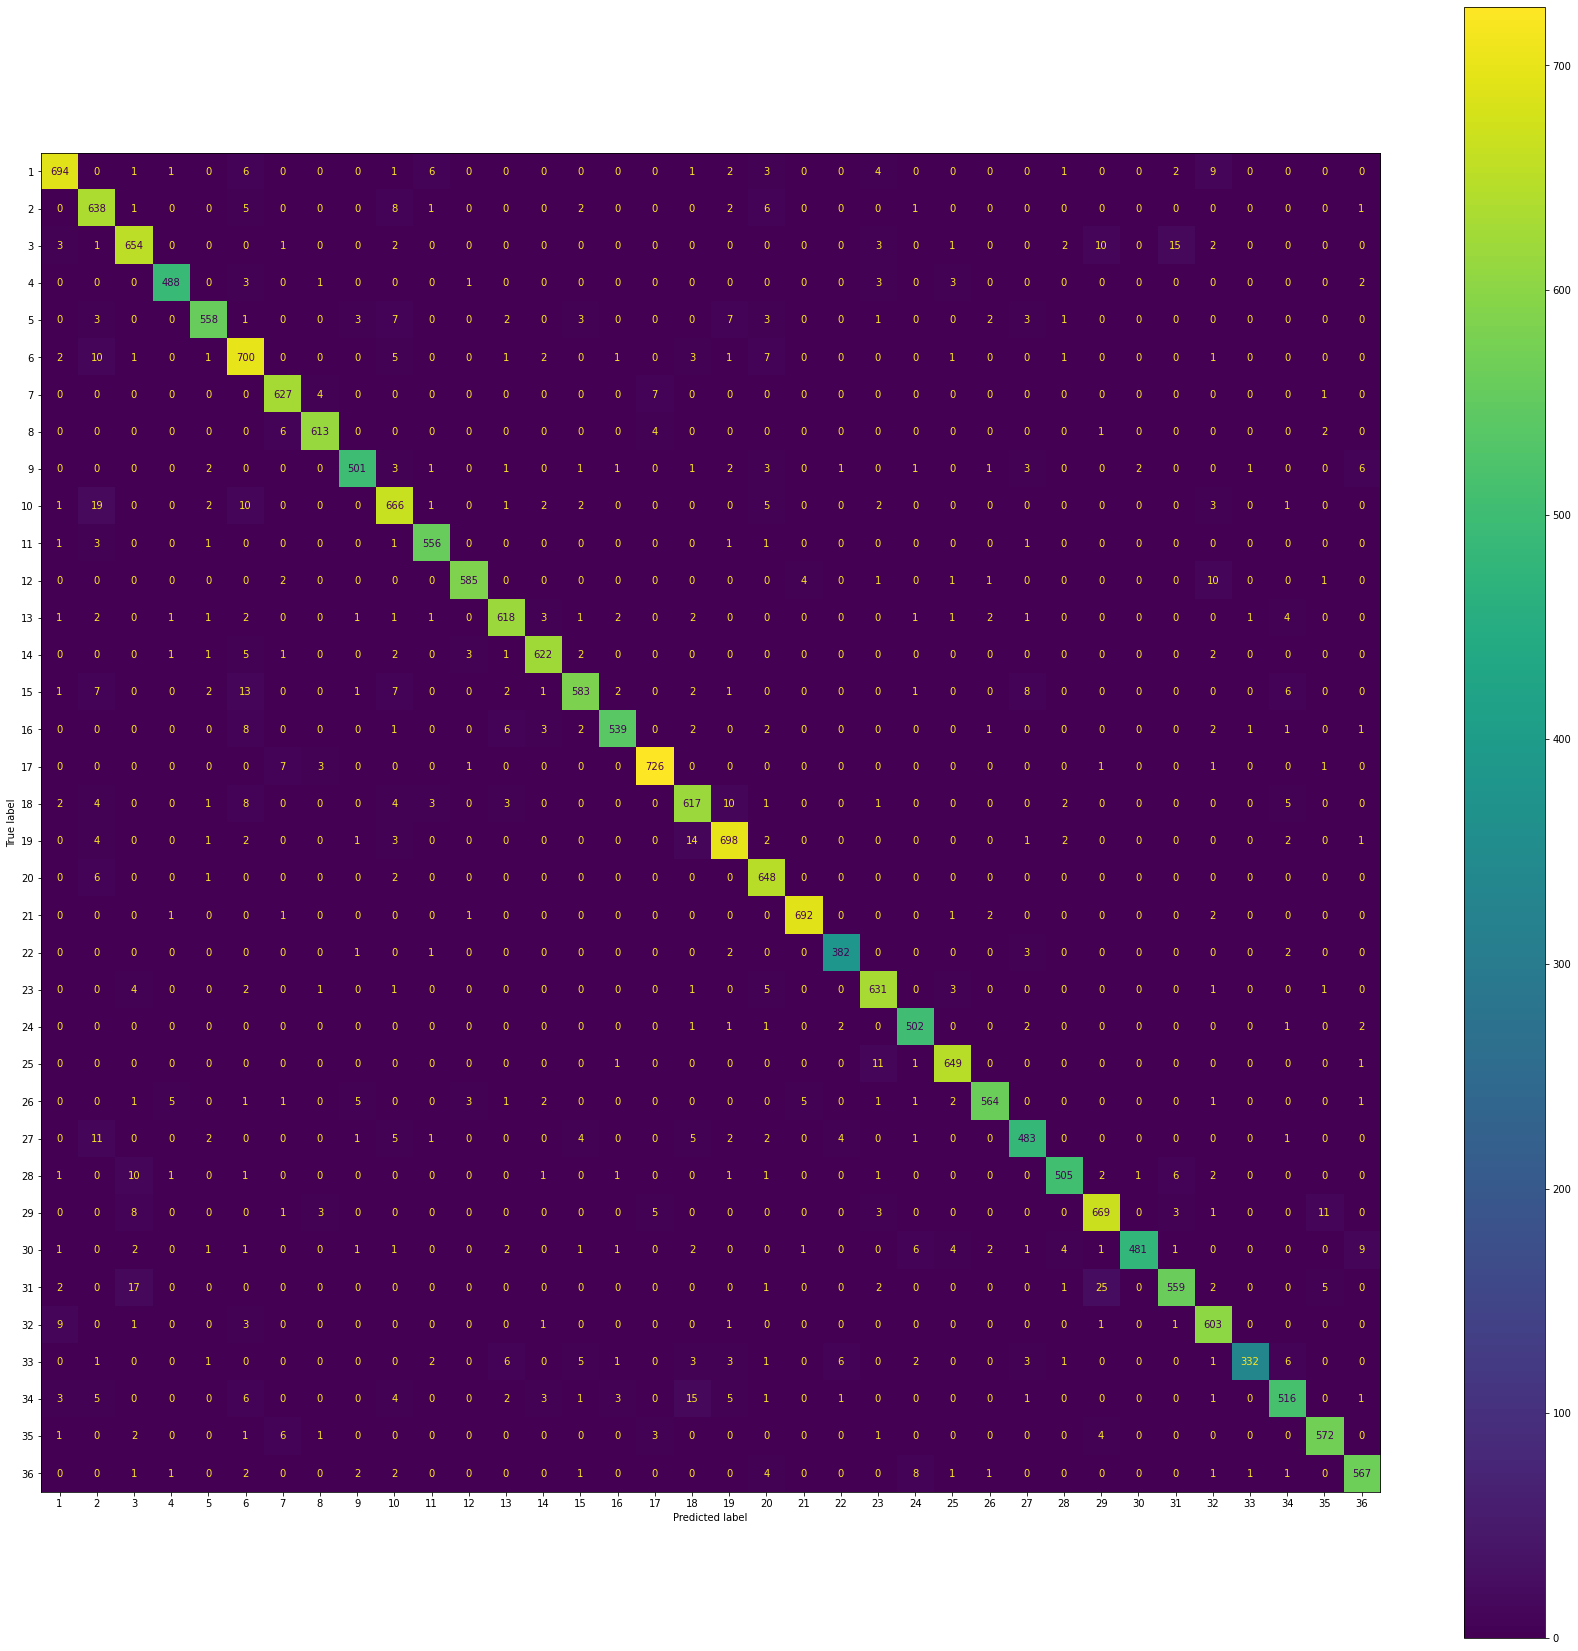

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_confusion_matrix(model,x_test, y_test,ax=ax,values_format='d')
plt.show()

In [ ]:
cv = cross_val_score(model, x_train,y_train, cv=10, n_jobs = -1,scoring = 'accuracy')
print(f"Cross Validation Accuracy: {np.average(cv)*100:.2f}")

Cross Validation Accuracy: 94.79


In [ ]:
print(model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
print(cv)

[0.81414702 0.80291262 0.80984743 0.80291262 0.8036061  0.80957004
 0.80443828 0.80443828 0.81373093 0.80846047]
